# MIE524 - Assignment 4
Please complete this notebook for Assignment 4.

## Q1 - PageRank

### Spark Setup

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u432-ga~us1-0ubuntu2~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u432-ga~us1-0ub

Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from tqdm import tqdm

%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Initialize Spark Context

In [3]:
# create the session
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Load Data

In [6]:
# loads the input file as an RDD, with each element being a string
# of the form "source destination" where source and destination
# are node id's representing the directed edge from node source
# to node destination. Note that the elements of this RDD are string
# types, hence you will need to map them to integers later.

lines = sc.textFile("q1-graph-full.txt")

In [7]:
lines.take(5)

['1\t2', '2\t3', '3\t4', '4\t5', '5\t6']

### a) PageRank Implementation

In [8]:
class my_PageRank:
    def __init__(self, lines, num_iterations, beta):
        """
        Initializes the my_PageRank object
        """
        self.lines = lines
        self.num_iterations = num_iterations
        self.beta = beta
        self.M = self.create_M()

    def create_M(self):
        """
        Generate the source destination matrix M
        """

        # TODO: YOUR CODE HERE
        def split_line(line):
            line = line.split("\t")
            source = int(line[0])
            dest = int(line[1])
            return (source,dest)
        def fill_M(row_idx, row, lines, sources_count):
            edges = lines.value
            for col_idx in range(len(row)):
                edge = (col_idx+1, row_idx+1)
                if edge in edges:
                    row[col_idx] = 1/sources_count[col_idx+1]
            return row
        lines = self.lines
        lines = lines.map(split_line) #change each line to (source, destination)
        lines = lines.distinct() #Remove duplicated directed edges, Note: A->B != B->A

        n = lines.flatMap(lambda x: x).max()
        self.n = n #n represents the total number of nodes

        #Get the number of out edges in each node
        sources = lines.map(lambda l: (l[0], 1))
        sources_count = sources.reduceByKey(lambda x,y:(x+y))
        sources_count = dict(sources_count.collect())


        edges_list = lines.collect()
        edges_broadcast = sc.broadcast(edges_list)
        M = sc.parallelize(range(n)).map(lambda row_idx: [0] * n) #Create a matrix of nxn filled with 0
        M = M.zipWithIndex().map(lambda row: fill_M(row[1], row[0], edges_broadcast, sources_count)) #Fill up Matrix M
        return M

    def compute_PageRank(self):
        """
        Run the entire PageRank algorithm
        """
        # 1. Initialize r^0
        # 2. Iteratively compute r^i

        # TODO: YOUR CODE HERE

        # Initializing r^0
        n = self.n
        r = np.full(n, 1/n)

        # compute r^i
        M = self.M
        beta = self.beta

        tel = np.full(n, (1-beta)/n) #Teleport Matrix
        for i in tqdm(range(self.num_iterations)):
            r_broadcast = sc.broadcast(r)
            r = M.map(lambda M_row: beta*np.dot(M_row, r_broadcast.value)).collect() #Doing matrix multiplication
            r = np.array(r) + tel

            r_broadcast.unpersist()
        return r

In [9]:
# initialize my_PageRank object
pg = my_PageRank(lines = lines, num_iterations = 40, beta = 0.8)


In [10]:
r = pg.compute_PageRank()
r

100%|██████████| 40/40 [19:06<00:00, 28.66s/it]


array([0.00114126, 0.00081032, 0.00073449, 0.00161361, 0.00113683,
       0.00128746, 0.00111545, 0.00100457, 0.00085827, 0.00145924,
       0.00092707, 0.00079051, 0.00074203, 0.00072442, 0.00109081,
       0.00179165, 0.00108482, 0.00100167, 0.00067958, 0.00105333,
       0.00120588, 0.00078686, 0.00090348, 0.00073999, 0.00078159,
       0.00064479, 0.00123237, 0.00105735, 0.00094836, 0.00082036,
       0.00073574, 0.00125578, 0.00073175, 0.00087024, 0.0011502 ,
       0.00066473, 0.00069661, 0.00055652, 0.00121579, 0.00103709,
       0.00075403, 0.00121014, 0.0012753 , 0.00079432, 0.00100303,
       0.0012449 , 0.00085077, 0.00156903, 0.00109996, 0.00052871,
       0.000934  , 0.00086908, 0.00124912, 0.00128154, 0.00081691,
       0.00150668, 0.00112692, 0.00111286, 0.00091431, 0.00089602,
       0.00114566, 0.00035315, 0.0005708 , 0.00045994, 0.00085509,
       0.0011283 , 0.00064858, 0.00057769, 0.00081708, 0.00065419,
       0.00103249, 0.00100569, 0.00077321, 0.00046723, 0.00096

### b) Compute the top 5 node ids with the highest PageRank scores.

In [11]:
# TODO: YOUR CODE HERE
d = dict()
for i in range(len(r)):
  d[i+1] = r[i]
sorted_d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
ids = list(sorted_d.keys())
scores = list(sorted_d.values())
for i in range(5):
  print(f"Top {i+1}: id = {ids[i]}, score = {scores[i]}")

Top 1: id = 263, score = 0.0020202911815182184
Top 2: id = 537, score = 0.0019433415714531497
Top 3: id = 965, score = 0.0019254478071662627
Top 4: id = 243, score = 0.001852634016241731
Top 5: id = 285, score = 0.0018273721700645144


### c) Compute the top 5 node ids with the lowest PageRank scores.

In [12]:
# TODO: YOUR CODE HERE
for i in range(1,6):
  print(f"Top {i} Lowest: id = {ids[-i]}, score = {scores[-i]}")

Top 1 Lowest: id = 558, score = 0.0003286018525215297
Top 2 Lowest: id = 93, score = 0.00035135689375165774
Top 3 Lowest: id = 62, score = 0.00035314810510596274
Top 4 Lowest: id = 424, score = 0.0003548153864930145
Top 5 Lowest: id = 408, score = 0.00038779848719291705


In [13]:
# stop the spark instance
sc.stop()

## Q2 - K-Means

In [14]:
# create new spark instance

# create the session
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Load Data

In [15]:
# loads the input file as an RDD, with each element being a string
documents = sc.textFile("q2-data.txt")
documents = documents.map(lambda x: [float(i) for i in x.split()])#Convert to float

c1 = sc.textFile("q2-c1.txt")
c1 = c1.map(lambda x: [float(i) for i in x.split()])#Convert to float

c2 = sc.textFile("q2-c2.txt")
c2 = c2.map(lambda x: [float(i) for i in x.split()])#Convert to float


In [16]:
documents.take(3)

[[0.0,
  0.64,
  0.64,
  0.0,
  0.32,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.64,
  0.0,
  0.0,
  0.0,
  0.32,
  0.0,
  1.29,
  1.93,
  0.0,
  0.96,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.778,
  0.0,
  0.0,
  3.756,
  61.0,
  278.0,
  1.0],
 [0.21,
  0.28,
  0.5,
  0.0,
  0.14,
  0.28,
  0.21,
  0.07,
  0.0,
  0.94,
  0.21,
  0.79,
  0.65,
  0.21,
  0.14,
  0.14,
  0.07,
  0.28,
  3.47,
  0.0,
  1.59,
  0.0,
  0.43,
  0.43,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.07,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.132,
  0.0,
  0.372,
  0.18,
  0.048,
  5.114,
  101.0,
  1028.0,
  1.0],
 [0.06,
  0.0,
  0.71,
  0.0,
  1.23,
  0.19,
  0.19,
  0.12,
  0.64,
  0.25,
  0.38,
  0.45,
  0.12,
  0.0,
  1.75,
  0.06,
  0.06,
  1.

### Implement K-Means

In [17]:
# function to compute Euclidean distance between point A and B
def euclidean_distance(A, B):
    return np.sqrt(np.sum(np.square(np.subtract(A, B))))

# function to compute cost function phi
def compute_phi(closest_centroids):
    # TODO: YOUR CODE HERE
    #closest_centroids is a rdd which contains (closest centroid, distance to closest centroid) for each datapoint
    min_distances = closest_centroids.map(lambda line: (line[1])**2)
    return min_distances.sum()

In [18]:
# function to compute Manhattan distance between point A and B
def manhattan_distance(A, B):
    return np.sum(np.abs(np.subtract(A, B)))

# function to compute cost function psi
def compute_psi(closest_centroids):
    # TODO: YOUR CODE HERE
    min_distances = closest_centroids.map(lambda line: line[1])
    return min_distances.sum()

In [19]:
class my_kmeans:
    def __init__(self, data, centroids, k, max_iter, distance_measure):
        """
        Initializes the my_PageRank object
        """
        self.data = data
        self.centroids = centroids
        self.k = k
        self.max_iter = max_iter

        self.distance_measure = distance_measure

    def run_kmeans(self):
        """
        Run the entire K-Means algorithm, return list of centroids, list of assignments, and list of costs
        """

        # TODO: YOUR CODE HERE
        def find_closest_centroid(datapoint,centroids,distance_measure):
            #Find the closest centroid for a datapoint given a list of centroids
            min_c = None
            min_distance = float('inf')
            for i, c in enumerate(centroids):
              distance = distance_measure(datapoint, c)
              if distance < min_distance: #Also catches the case of equidistant centroids
                min_c = i
                min_distance = distance
            return (min_c, min_distance)
        def map_point_centroid(row_idx, row):
            centroid = row[0]
            return (centroid, [row_idx]) #(centroid, [datapoint_id])
        costs = []

        centroids = self.centroids
        centroids = centroids.collect()
        data = self.data
        distance_measure = self.distance_measure
        data_with_index = data.zipWithIndex()
        for i in range(self.max_iter):

            #Assign all datapoints to the closest centroid
            broadcast_centroids = sc.broadcast(centroids)
            closest_centroids = data.map(lambda datapoint: find_closest_centroid(datapoint, broadcast_centroids.value, distance_measure))

            #Calculate cost for this iteration
            if distance_measure is euclidean_distance:
                cost = compute_phi(closest_centroids)
                if i == 0:
                    print("Using euclidean distance")
            else:
                cost = compute_psi(closest_centroids)
                if i == 0:
                    print("Using Manhattan distance")
            costs.append(cost)

            #Recompute centroids as mean of all datapoints assigned to each centroid
            closest_centroids = closest_centroids.zipWithIndex().map(lambda row: map_point_centroid(row[1], row[0])) #map to (centroid, [datapoint_id])
            closest_centroids = closest_centroids.reduceByKey(lambda a, b: a + b) #we got (centroid_i, [all datapoint_id assigned to centroid_i])
            closest_centroids = closest_centroids.collect()

            for key, value in closest_centroids: #for each centroid and all datapoints assigned to that centroid
                #compute the mean
                datapoints = data_with_index.filter(lambda x: x[1] in value).map(lambda x: np.array(x[0]))
                length = datapoints.count()
                mean = datapoints.reduce(lambda a, b: a + b)
                # mean = np.array(mean.collect())
                mean = mean/length

                #assign mean to that centroid
                centroids[key] = list(mean)
        #assignments
        return centroids, costs

### a) Using Euclidean distance to compute phi(i) for every iteration i.

In [20]:
# initialize my_kmeans class
km = my_kmeans(data=documents, centroids = c1, k = 10, max_iter = 20, distance_measure=euclidean_distance)
km2 = my_kmeans(data=documents, centroids = c2, k = 10, max_iter = 20, distance_measure=euclidean_distance)

In [21]:
# Get a list of costs phi

# TODO: YOUR CODE HERE
centroids, costs = km.run_kmeans()
centroids_c2, costs_c2 = km2.run_kmeans()

Using euclidean distance
Using euclidean distance


Use the below cell to plot the graphs.

In [22]:
def plot_costs(costs, c):
    iterations = list(range(1,21))
    plt.plot(iterations, costs)
    plt.title(f"Costs for {c}.txt")
    plt.xlabel("Iterations")
    plt.ylabel("Costs")
    plt.grid(True)
    plt.show()

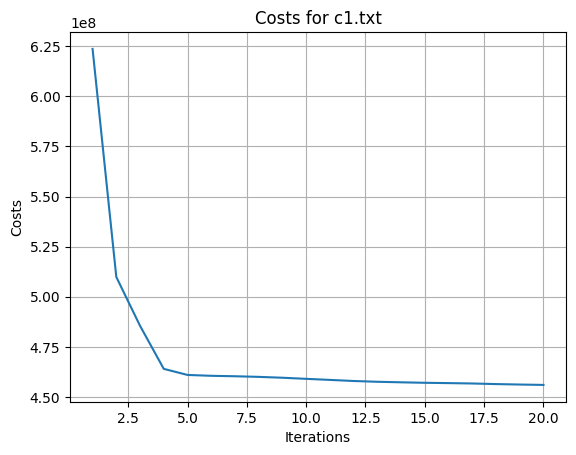

In [23]:
# Generate a plot for c1.txt

# TODO: YOUR CODE HERE
plot_costs(costs, "c1")

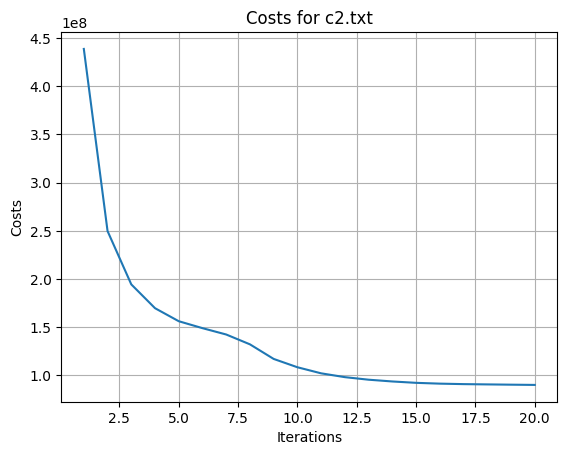

In [24]:
# Generate a plot for c2.txt

# TODO: YOUR CODE HERE
plot_costs(costs_c2,"c2")

### b) Compute percentage change in cost after 10 iterations of the K-Means algorithm.

In [25]:
def get_percent_change(costs, c):
    change = (costs[0]-costs[10])/ costs[0]
    print(f"Percentage change in cost for {c} = {change*100}%")

In [26]:
# percentage change in cost for c1.

# TODO: YOUR CODE HERE
get_percent_change(costs, "c1")

Percentage change in cost for c1 = 26.483917144560547%


In [27]:
# percentage change in cost for c2.

# TODO: YOUR CODE HERE
get_percent_change(costs_c2, "c2")

Percentage change in cost for c2 = 76.69795594605947%


Use the below cell for your written explanation.

The initialization using c2.txt is better than random initialization using c1.txt. From the graph, c2 has less initial cost than c1 and c2 is able to converge to a much lower cost than c1. Other than that, c2 is able to reduce its cost for over 75% compared to c1 with only 26.5%, meaning c2 is able to find a much better grouping compared to the initialization and c1 cannot. All of these come from the fact that c2 initializes clusters that are close to global minima, while c1 has more chance to get stuck at local optima.

### c) Using Manhattan distance to compute phi(i) for every iteration i.

In [30]:
# initialize my_kmeans class
km = my_kmeans(data=documents, centroids = c1, k = 10, max_iter = 20, distance_measure=manhattan_distance)
km2 = my_kmeans(data=documents, centroids = c2, k = 10, max_iter = 20, distance_measure=manhattan_distance)

In [31]:
# Get a list of costs psi

# TODO: YOUR CODE HERE
centroids, costs = km.run_kmeans()
centroids_c2, costs_c2 = km2.run_kmeans()

Using Manhattan distance
Using Manhattan distance


Use the below cell to plot the graphs.

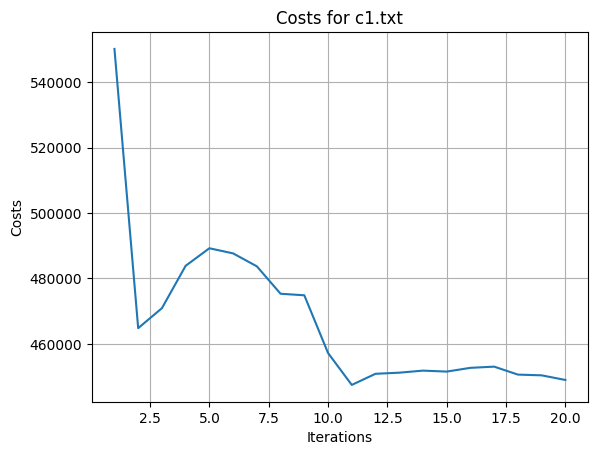

In [32]:
# Generate a plot for c1.txt

# TODO: YOUR CODE HERE
plot_costs(costs, "c1")

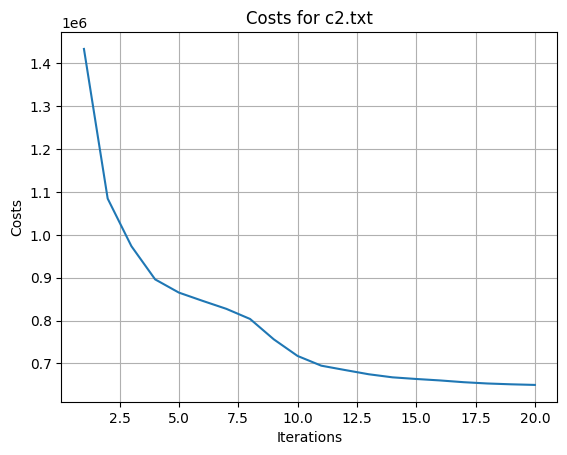

In [33]:
# Generate a plot for c2.txt

# TODO: YOUR CODE HERE
plot_costs(costs_c2, "c2")

### d) Compute percentage change in cost after 10 iterations of the K-Means algorithm.

In [34]:
# percentage change in cost for c1.

# TODO: YOUR CODE HERE
get_percent_change(costs, "c1")

Percentage change in cost for c1 = 18.65492611679923%


In [35]:
# percentage change in cost for c2.

# TODO: YOUR CODE HERE
get_percent_change(costs_c2, "c2")

Percentage change in cost for c2 = 51.554099102389095%


Use the below cell for your written explanation.

From the graph, c2 initialization places the clusters in a worse position than c1 initialization. Even though KMeans performed better with c2 and reduced a lot of its initialization cost, the minimum cost from c1 is still lower than cost from c2. In conclusion, random initialization can sometimes place the clusters in a better position than c2, leading to a better result; however, c2 initialization guarantees that KMeans will get a good convergence.